## Let's attempt to build a image representation system using CLIP as base

The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

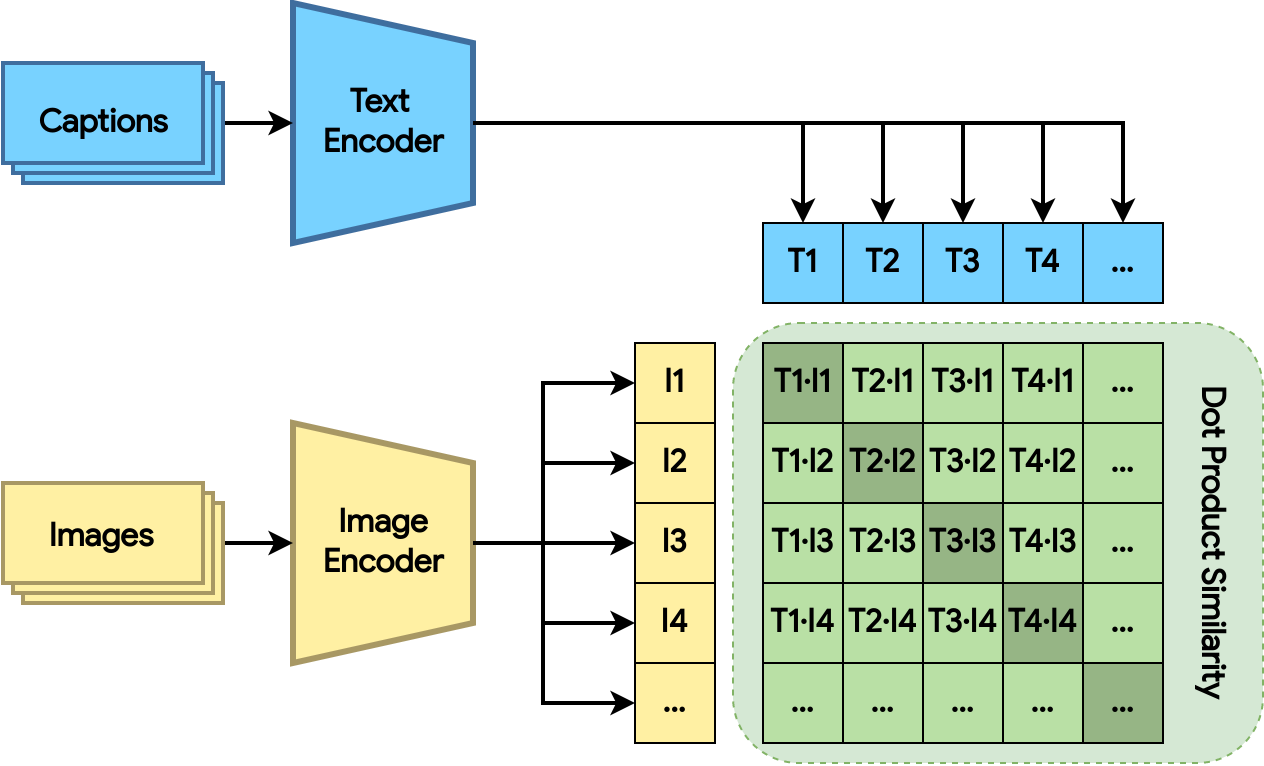

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install kaggle

In [3]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.8.1+cu111


In [3]:
##models available
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

## Lets use Flicker Images Dataset for testing purposes



In [14]:
# must put your kaggle api in /root/.kaggle/
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip flickr-image-dataset.zip -d flicker_data/

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, BatchSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
%matplotlib inline


In [74]:
#preprocess is just a sequential module
model, preprocess = clip.load("ViT-B/32")

In [7]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_csv("flicker_data/flickr30k_images/results.csv",sep="|")


In [8]:
# keep the first caption per image and use only 20% of the data for training
labels=labels[~labels.duplicated(subset="image_name",keep="first")].sample(frac=0.2)

In [ ]:
##sneak-a-peek of data

Image Caption:  A child in a pink dress is climbing up a set of stairs in an entry way .


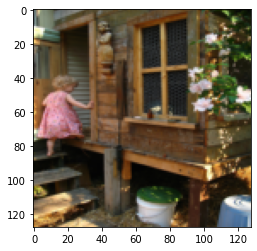

In [66]:
# do not run
print(f"""Image Caption: {labels[labels['image_name']==dataset.imgs[2][0].split("/")[-1]][' comment'].values[0]}""")
plt.imshow(dataset[2][0].permute(1, 2, 0));

In [9]:
import logging
import glob


logging.basicConfig(
                    level = logging.INFO,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')
logger=logging.getLogger()
logger.setLevel(logging.INFO)

## train-test-split

In [10]:
labels['captions']=labels[' comment'].map(lambda d: d.strip())

In [11]:
train,test=train_test_split(labels,train_size=0.7)
##make sure when using ImageFolder, idx positions match, ImageFolder will load files in ascending order by filename
train.sort_values(by="image_name",ascending=True,inplace=True)
test.sort_values(by="image_name",ascending=True,inplace=True)
print(train.shape,test.shape)

(4449, 4) (1908, 4)


<ipython-input-11-c13b7d11cf1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values(by="image_name",ascending=True,inplace=True)
<ipython-input-11-c13b7d11cf1b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values(by="image_name",ascending=True,inplace=True)


In [12]:
train.to_csv("train_labels.csv",sep=";",index=False)
test.to_csv("test_labels.csv",sep=";",index=False)

In [13]:
## create folders for train-test

import shutil
import os
from tqdm import tqdm

BASE_PATH="flicker_data/flickr30k_images/flickr30k_images"

if not os.path.isdir("flicker_data/train/images"):
    os.makedirs("flicker_data/train/images")

if not os.path.isdir("flicker_data/test/images"):
    os.makedirs("flicker_data/test/images")
        
for image in tqdm(train.image_name,desc="Copying train images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("flicker_data/train/images")/image)

for image in tqdm(test.image_name,desc="Copying test images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("flicker_data/test/images")/image)

Copying test images: 100%|██████████| 1908/1908 [00:09<00:00, 199.07it/s]


In [14]:
#using datasets.ImageFolder makes loading images and preprocessing easier
train_images = datasets.ImageFolder("./flicker_data/train/",transform=preprocess)
test_images = datasets.ImageFolder("./flicker_data/test/",transform=preprocess)

In [82]:
assert test.iloc[-1].image_name==test_images.imgs[-1][0].split("/")[-1]

In [15]:
len(test.captions.values.tolist())

1908

In [16]:
class FlickerDataset(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption':caption_idx}
        
    def __len__(self):
        return len(self.captions)
    
train_dataset = FlickerDataset(train.captions.values.tolist(), train_images)
test_dataset = FlickerDataset(test.captions.values.tolist(), test_images)
len(train_dataset), len(test_dataset)


(4449, 1908)

In [65]:
## create dataloaders
BATCH_SIZE=32
tr_dl=DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
ts_dl=DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE)

In [107]:
a=next(iter(ts_dl))

2022-10-13 15:35:10,153:WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


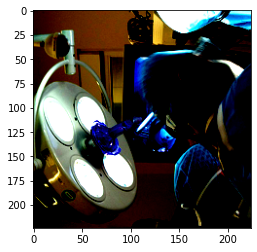

In [108]:
plt.imshow(img[0].detach().cpu().permute(2,1,0))

In [109]:
caption=clip.tokenize(a['caption'],truncate=True).to(DEVICE)
img=a['image'].to(DEVICE)

In [110]:
#model.to(DEVICE)
with torch.cuda.amp.autocast():
    logits_image, logits_caption = model(img, caption)

In [111]:
labels = torch.arange(len(img)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
img_loss=loss_img(logits_image,labels)
caption_loss=loss_caption(logits_caption,labels)
total_loss = (img_loss+caption_loss)/2

## Training Loop

In [67]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS=10
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

In [44]:
import wandb
run=wandb.init(project="clip-fine-tuning",name=f"run-1",config={"epochs": N_EPOCHS,"batch_size":BATCH_SIZE})

wandb: Currently logged in as: jfparra. Use `wandb login --relogin` to force relogin


In [114]:
if os.path.exists(Path("./checkpoints")/"best_model.pt"):
    print(1)

1


In [ ]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

model.to(DEVICE)


## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()
        

def train_model(n_epochs,train_dataloader,test_dataloader,checkpoint_path:str="./checkpoints"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    model.train()
    best_score=-9e10
    train_loss=0.0
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        for step,data in enumerate(tqdm(train_dataloader),1):
            
            optimizer.zero_grad()
            
            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            
            if step%100==0:
                logger.info(f"Epoch {epoch} | step loss:{train_loss/total_steps:.4f}")
                wandb.log({'train_loss':train_loss/total_steps})
        
        val_metrics=validate(test_dataloader)
        wandb.log({'test_loss':test_total_loss})
        logger.info(f"Epoch {epoch} end -> Validation Loss: {test_total_loss:.4f}")

        if val_metrics>best_score:
            print("Better score reached, saving checkpoint...")
            best_score=val_metrics
            if os.path.exists(Path(checkpoint_path)/"best_model.pt"):
                os.remove(Path(checkpoint_path)/"best_model.pt")
            torch.save(model.state_dict(), Path(checkpoint_path)/"best_model.pt")
            logger.info("Saving checkpoint to WANDB")
            wandb.save(Path(checkpoint_path)/"best_model.pt")
            
        
        scheduler.step()
        
        
            
            

        
def validate(test_dl):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in test"):
        img_batch=data['image'].to(DEVICE)
        captions_batch=clip.tokenize(data['caption']).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    return test_total_loss



train_model(N_EPOCHS,tr_dl,ts_dl)